[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/qmri_cardiac_fingerprinting.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:qmri_cardiac_fingerprinting.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebooks]

# Cardiac MR Fingerprinting

This notebook provides the image reconstruction and parameter estimation methods required to reconstruct cardiac MR
Fingerprinting (cMRF) data.


## Overview
In this notebook, data from a cardiac MR Fingerprinting (cMRF) experiment is reconstructed and
$T_1$ and $T_2$ maps are estimated. This example uses data from [Schuenke et al., 2024](in submission) of a phantom
consisting of 9 tubes. Average $T_1$ and $T_2$ are calculated for each tube.

The fingerprinting sequence, as described by [Hamilton et al., 2017](https://doi.org/10.1002/mrm.26668) and
[Schuenke et al., 2024](in submission), consists of three repetitions of the following 5-block structure:

In [2]:
# Block 0          Block 1          Block 2          Block 3          Block 4
# R-peak           R-peak           R-peak           R-peak           R-peak
# |----------------|----------------|----------------|----------------|----------------
# [INV][ACQ]           [ACQ]       [T2-prep][ACQ]      [T2-prep][ACQ]   [T2-prep][ACQ]

where [INV] represents an inversion pulse, [ACQ] an acquisition, and [T2-prep] a T2-preparation pulse.

We carry out dictionary matching to estimate $T_1$ and $T_2$ from a series of reconstructed qualitative images using
normalized dot product matching between the images and a dictionary of pre-calculated signals. Pixelwise, we find the
entry $d^*$ in the dictionary maximizing $\left|\frac{d}{\|d\|} \cdot \frac{y}{\|y\|}\right|$ for the reconstructed
signal $y$. The parameters $x$ generating the matching dictionary entry $d^*=d(x)$ are then used to estimate
the quantitative parameters.



In the following, we are going to:
- Download data from zenodo.
- Reconstruct the qualitative images using a sliding window reconstruction.
- Perform dictionary matching to estimate the quantitative parameters from the qualitative images.
- Visualize and evaluate results.
- Check if the cMRF results match the reference values.

In [3]:
# Download data from zenodo
import tempfile
from pathlib import Path

import zenodo_get

dataset = '15182376'

tmp = tempfile.TemporaryDirectory()  # RAII, automatically cleaned up
data_folder = Path(tmp.name)
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries

Title: Open-Source Cardiac MR Fingerprinting
Keywords: 
Publication date: 2025-04-09
DOI: 10.5281/zenodo.15182376
Total size: 34.8 MB

Link: https://zenodo.org/records/15182376/files/mask.npy   size: 131.2 kB



Checksum is correct. (2466688e183d940f1a3c4373d4854ba1)

Link: https://zenodo.org/records/15182376/files/cMRF.h5   size: 34.4 MB



Checksum is correct. (3877c02fc42066d9ea8678075edba1c6)

Link: https://zenodo.org/records/15182376/files/ref_t1.npy   size: 131.2 kB



Checksum is correct. (573efe0ea6a15989c518873fcd8a798c)

Link: https://zenodo.org/records/15182376/files/ref_t2.npy   size: 131.2 kB



Checksum is correct. (7059fff0a2b2b8794cb9b119fa4a44b1)
All files have been downloaded.


## Reconstruct qualitative images
We first load the data from a downloaded ISMRMRD file.

In [4]:
import mrpro

kdata = mrpro.data.KData.from_file(data_folder / 'cMRF.h5', mrpro.data.traj_calculators.KTrajectoryIsmrmrd())

We want to perform a sliding window reconstruction respecting the block structure of the acquisition.
We construct a split index that splits the data into windows of 20 acquisitions with an overlap of 10 acquisitions.
Here, we can make use of the indexing functionality of `~mrpro.data.KData` to split the data into windows.

In [5]:
import torch

n_acq_per_image = 20
n_overlap = 10
n_acq_per_block = 47
n_blocks = 15

idx_in_block = torch.arange(n_acq_per_block).unfold(0, n_acq_per_image, n_acq_per_image - n_overlap)
split_indices = (n_acq_per_block * torch.arange(n_blocks)[:, None, None] + idx_in_block).flatten(end_dim=1)
kdata_split = kdata[..., split_indices, :]

We can now perform the reconstruction for each window. We first perform an averaged reconstruction over all
acquisitions to get a good estimate of the coil sensitivities before performing the windowed reconstruction.

In [6]:
avg_recon = mrpro.algorithms.reconstruction.DirectReconstruction(kdata)
recon = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_split, csm=avg_recon.csm)
img = recon(kdata_split)

## Dictionary matching
Next, we calculate the dictionary.
First, we set up the `~mrpro.operators.models.CardiacFingerprinting` operator and an `~mrpro.operators.AveragingOp`
operator. This `~mrpro.operators.AveragingOp` mimics the averaging performed by the sliding window reconstruction
and applies it to the simulated signals generated by the `~mrpro.operators.models.CardiacFingerprinting` model.

In [7]:
model = mrpro.operators.AveragingOp(dim=0, idx=split_indices) @ mrpro.operators.models.CardiacFingerprinting(
    kdata.header.acq_info.acquisition_time_stamp.squeeze(),
    echo_time=0.00155,
    repetition_time=0.01,
    t2_prep_echo_times=(0.03, 0.05, 0.1),
)

Next, we pass this signal model to the  `~mrpro.operators.DictionaryMatchOp` operator to create a dictionary.

In [8]:
dictionary = mrpro.operators.DictionaryMatchOp(model, index_of_scaling_parameter=0)

Next, we choose a suitable range of $T_1$ and $T_2$ values for the
dictionary. We can keep $M_0$ constant at ``1.0``, as dictionary matching is invariant to a scaling factor.
By adding these keys to the dictionary, the `~mrpro.operators.DictionaryMatchOp` operator will use the signal
model to calculate the dictionary entries for the given $M_0$, $T_1$ and $T_2$ values.

In [9]:
t1_keys = torch.arange(0.05, 2, 0.01)[:, None]
t2_keys = torch.arange(0.006, 0.2, 0.002)[None, :]
m0_keys = torch.tensor(1.0)
dictionary.append(m0_keys, t1_keys, t2_keys)

DictionaryMatchOp(
  (_f): OperatorComposition(
    (_operator1): AveragingOp()
    (_operator2): CardiacFingerprinting(
      (sequence): EPGSequence(
        (0): EPGSequence(
          (0): InversionBlock()
          (1): FispBlock()
        )
        (1): DelayBlock()
        (2): EPGSequence(
          (0): FispBlock()
        )
        (3): DelayBlock()
        (4): EPGSequence(
          (0): T2PrepBlock()
          (1): FispBlock()
        )
        (5): DelayBlock()
        (6): EPGSequence(
          (0): T2PrepBlock()
          (1): FispBlock()
        )
        (7): DelayBlock()
        (8): EPGSequence(
          (0): T2PrepBlock()
          (1): FispBlock()
        )
        (9): DelayBlock()
        (10): EPGSequence(
          (0): InversionBlock()
          (1): FispBlock()
        )
        (11): DelayBlock()
        (12): EPGSequence(
          (0): FispBlock()
        )
        (13): DelayBlock()
        (14): EPGSequence(
          (0): T2PrepBlock()
          (1):

We can now perform the dictionary matching by passing the reconstructed image data to the
`~mrpro.operators.DictionaryMatchOp` operator.

In [10]:
m0_match, t1_match, t2_match = dictionary(img.data[:, 0, 0, 0])

## Visualize and evaluate results
Great! Now we can visualize and evaluate the results. We can plot the cMRF $T_1$ and $T_2$ maps:

In [11]:
import matplotlib.pyplot as plt
from cmap import Colormap


def show_image(t1: torch.Tensor, t2: torch.Tensor) -> None:
    """Show the cMRF $T_1$ and $T_2$ maps."""
    cmap_t1 = Colormap('lipari')
    cmap_t2 = Colormap('navia')
    fig, ax = plt.subplots(2, 1)

    im = ax[0].imshow(t1.numpy(force=True), vmin=0, vmax=2, cmap=cmap_t1.to_mpl())
    ax[0].set_title('cMRF T1 (s)')
    ax[0].set_axis_off()
    plt.colorbar(im)

    im = ax[1].imshow(t2.numpy(force=True), vmin=0, vmax=0.2, cmap=cmap_t2.to_mpl())
    ax[1].set_title('cMRF T2 (s)')
    ax[1].set_axis_off()
    plt.colorbar(im)

    plt.tight_layout()
    plt.show()

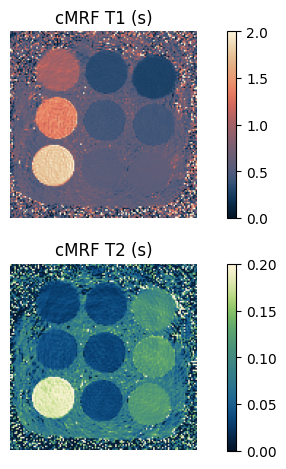

In [12]:
show_image(t1_match, t2_match)

We can also plot the statistics of the cMRF $T_1$ and $T_2$ maps and compare them to pre-calculated reference values,
obtained from a separate reference scan.

In [13]:
import numpy as np


def image_statistics(idat: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """Calculate mean value and standard deviation in the ROIs."""
    mask = np.squeeze(np.load(data_folder / 'mask.npy'))
    n_tubes = 9
    mean = torch.stack([torch.mean(idat[mask == idx]) for idx in range(1, n_tubes + 1)])
    std_deviation = torch.stack([torch.std(idat[mask == idx]) for idx in range(1, n_tubes + 1)])
    return mean, std_deviation


def r_squared(true: torch.Tensor, predicted: torch.Tensor) -> float:
    """Calculate the coefficient of determination (R-squared)."""
    total = ((true - true.mean()) ** 2).sum()
    residual = ((true - predicted) ** 2).sum()
    r2 = 1 - residual / total
    return r2.item()

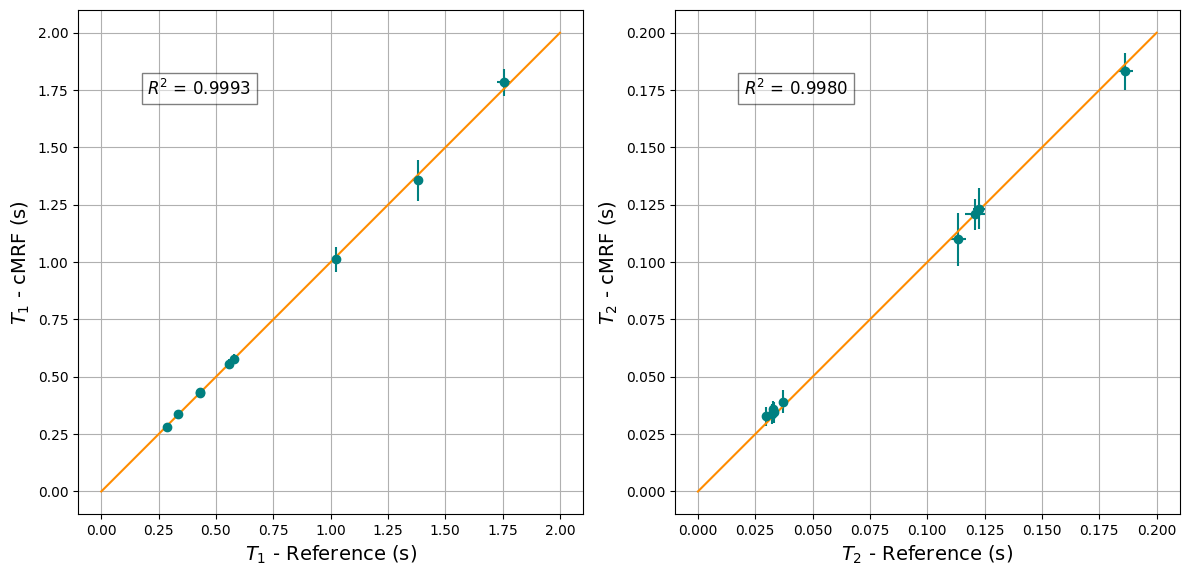

In [14]:
# Loading of reference maps and time conversion from ms to s
ref_t1_maps = torch.tensor(np.load(data_folder / 'ref_t1.npy')) / 1000
ref_t2_maps = torch.tensor(np.load(data_folder / 'ref_t2.npy')) / 1000
t1_mean_ref, t1_std_ref = image_statistics(ref_t1_maps)
t2_mean_ref, t2_std_ref = image_statistics(ref_t2_maps)
t1_mean_cmrf, t1_std_cmrf = image_statistics(t1_match)
t2_mean_cmrf, t2_std_cmrf = image_statistics(t2_match)

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].errorbar(t1_mean_ref, t1_mean_cmrf, t1_std_cmrf, t1_std_ref, fmt='o', color='teal')
ax[0].plot([0, 2.0], [0, 2.0], color='darkorange')
ax[0].text(
    0.2,
    1.800,
    rf'$R^2$ = {r_squared(t1_mean_ref, t1_mean_cmrf):.4f}',
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='left',
    bbox={'facecolor': 'white', 'alpha': 0.5},
)
ax[0].set_xlabel('$T_1$ - Reference (s)', fontsize=14)
ax[0].set_ylabel('$T_1$ - cMRF (s)', fontsize=14)
ax[0].grid()
ax[0].set_aspect('equal', adjustable='box')

ax[1].errorbar(t2_mean_ref, t2_mean_cmrf, t2_std_cmrf, t2_std_ref, fmt='o', color='teal')
ax[1].plot([0, 0.2], [0, 0.2], color='darkorange')
ax[1].text(
    0.02,
    0.180,
    rf'$R^2$ = {r_squared(t2_mean_ref, t2_mean_cmrf):.4f}',
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='left',
    bbox={'facecolor': 'white', 'alpha': 0.5},
)
ax[1].set_xlabel('$T_2$ - Reference (s)', fontsize=14)
ax[1].set_ylabel('$T_2$ - cMRF (s)', fontsize=14)
ax[1].grid()
ax[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [15]:
# Assertion verifies if cMRF results match the pre-calculated reference values
torch.testing.assert_close(t1_mean_ref, t1_mean_cmrf, atol=0, rtol=0.15)
torch.testing.assert_close(t2_mean_ref, t2_mean_cmrf, atol=0, rtol=0.15)